**Lab 6: IIR Filtering**


The objective for this lab is to help you understand the relationship between the location
of poles and zeros in the z-domain, the impulse response h[n] in the n-domain, and the frequency
response $H(e^{j\omega})$. We use the system function,
represented as a ratio of polynomials in $z^{-1}$, which can be expressed in either factored or expanded form as:

$$
H(z) = G\frac{\prod_{k=1}^M (1-z_kz^{-1}) }{\prod_{k=1}^N (1-p_kz^{-1})} = \frac{ \sum_{k=0}^M b_kz^{-k}}{ 1- \sum_{k=1}^N a_kz^{-k} }
$$

In [2]:
import numpy as np
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

from util import load_audio, plot_signals, plot_spectrogram, plot_frequency_response

**1. IIR filters to extract the envelope**

In the previous labs, you extracted the envelope from your reference signal by applying the following system:

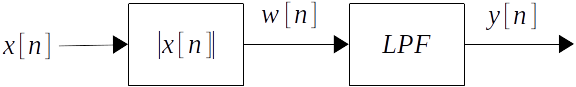

where $w[n] = |x[n]|$ and $y[n]$ was the output of a low-pass FIR filter (averaging filter). In this exercise, you will re-implement this low-pass filter as an IIR.

1.1 First, copy the functions envelope and synthesize from previous work and obtain the same synthesis. 



In [3]:
# Write your code here
def envelope(x, N):
    if N < 1:
      raise ValueError(" at least 1")

    # Step 1: Full-wave rectifier (absolute value)
    # Step 2: Apply N-point averaging filter to the rectified signal
    rectified_signal = np.abs(x)
    filter_coeffs = np.ones(N) / N
    envelope_signal = np.convolve(rectified_signal, filter_coeffs, mode='same')

    return envelope_signal

def synthesize(f0, phi, Ak, t):
  y = 0
  for k in range(1, len(Ak) + 1):
    y += Ak[k-1] * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)
  return y


1.2 Let's take a look at the following system:

$$
H(z) = G\frac{1+z^{-1}}{1-rz^{-1}} \quad   0<r<1 \quad, G = \frac{1-r}{2}
$$

Note that the coefficients of the filter are the following:

$$
b_0 = 1, \quad b_1 = 1, \quad a_0 = 1, \quad a_1 = -r, \quad
$$

i. Find the zeros and poles of the system analytically.

We transform H(z) to H(z)=G(z+1)/(z-r) (multiplying numerator and denominator by z)
With this we determine that the zeroes exist where z+1 = 0 and the poles at z-r = 0;
Thus, there is a zero at z = -1 and a pole at z = r  

ii. Use the function `np.roots` to find the zeros and poles using Python. Compare the results with part i.

In [4]:
# Write your code here
# Define the coefficients for the numerator and denominator
r = 0.5  # Example value for r, 0 < r < 1
G = (1 - r) / 2

numerator = [1, 1]  # Coefficients of z + 1
denominator = [1, -r]  # Coefficients of z - r

# Find zeros and poles using np.roots
zeros = np.roots(numerator)
poles = np.roots(denominator)

zeros, poles

(array([-1.]), array([0.5]))

iii. Use the function  `plot_zeros_poles(z, p)` to plot the zeros and poles found in ii.

In [5]:
from util import plot_zeros_poles

# Write your code here
plot_zeros_poles(zeros, poles)

1.3 Let's see the frequency response of this filter:



In [6]:
ww = np.arange(-np.pi, np.pi, np.pi/500)
r = 0.9
G = (1 - r)/2
_, HH = signal.freqz([G, G], [1 , -r], ww)

plot_frequency_response(ww, HH)

1.4. Change the parameter $r$ in the range $(0, 1)$. What happens when $r$ is increased?

The frequency response gets narrower

1.5 What type of filter is (low-pass, band-pass, or high-pass filter)?


band-pass filter, because as we see in the magnitude part of the frequency response we only allow a small part to have magnitude different than 0

1.6 Now we can use this IIR filter to extract the envelope. Let's define a new function `envelope_iir(x)` that applies the filter to the absolute value of the signal. Note that we are using signal.lfilter function to apply the filter.


In [7]:
def envelope_iir(x, r=0.995):
  G = (1 - r)/2
  y = signal.lfilter([G, G], [1, -r], np.abs(x))
  return y

Extract the envelope of your reference signal using both the FIR and IIR filters and compare the results plot them along with the signal. Change the value of $r$ until you are comfortable with the result.

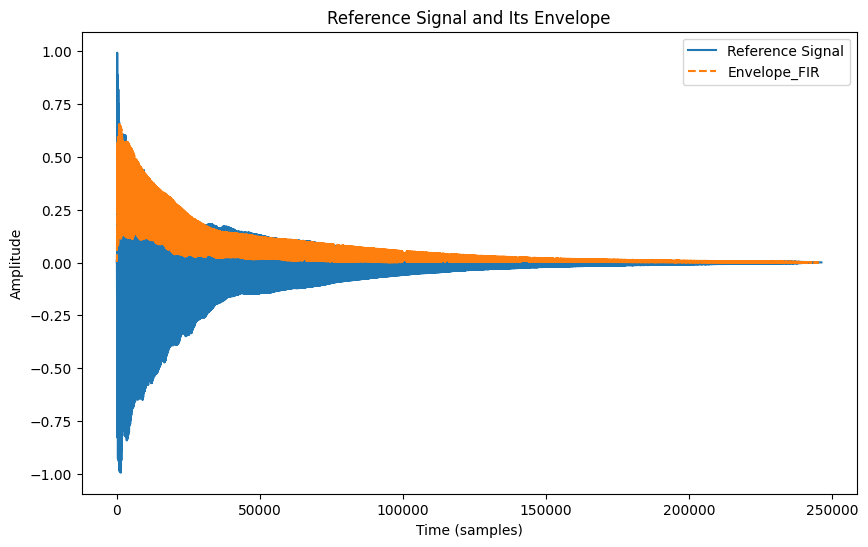

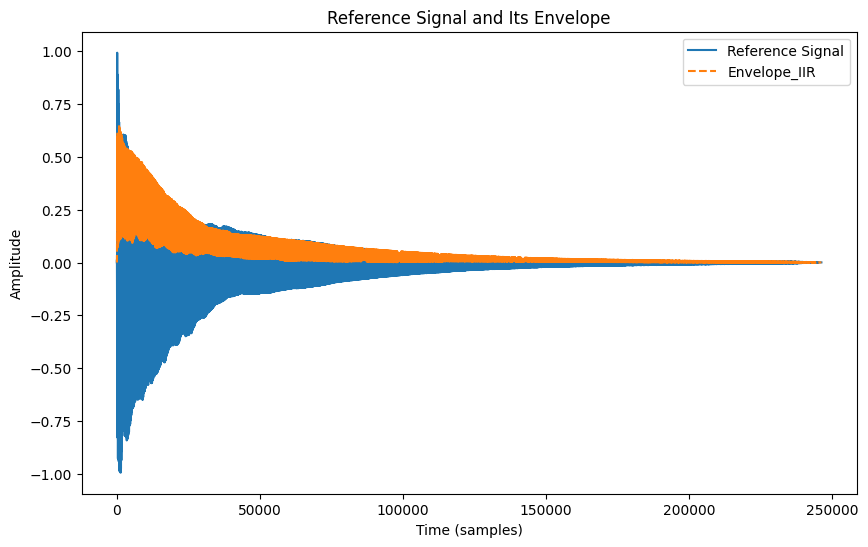

In [22]:
# Write your code here
filepath = "./-sis1_group4/44733__casualdave__601e.wav"
ref, fs = load_audio(filepath)
envelope_signal_FIR = envelope(ref,15) #N = 15 from lab4
plt.figure(figsize=(10, 6))
plt.plot(ref, label='Reference Signal')
plt.plot(envelope_signal_FIR, label='Envelope_FIR', linestyle='--')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Reference Signal and Its Envelope')
plt.legend()
plt.show()

envelope_signal_IIR = envelope_iir(ref,0.86)
plt.figure(figsize=(10, 6))
plt.plot(ref, label='Reference Signal')
plt.plot(envelope_signal_IIR, label='Envelope_IIR', linestyle='--')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Reference Signal and Its Envelope')
plt.legend()
plt.show()

1.7 What are the main differences between the two filters? For instance, compare the number of coefficients.

Firstly, the coefficent of the IIR filter is limited from 0 to 1, thus much smaller than the coefficient for the FIR filter which is 15. 

1.8 Apply the new envelope (extracted from the IIR filter) to the synthesis generated with the `synthesize` function and listen to the result.

In [23]:
# Write your code here
f_0 = 328.38
phi = -np.pi/2
t = np.arange(0, 4, 1.0/fs)
weights = [1, 0.381, 0.207, 0.134, 0.258, 0.106, 0.037, 0.082, 0.076, 0.009]
y_1 = synthesize(f_0, phi, weights, t)
enveloped_y_1 = envelope_iir(y_1,0.86)

In [24]:
ipd.Audio(enveloped_y_1, rate=fs)

---

**2. Band-pass filters**

Now let's work with the following system: 

$$
H(z) = \frac{(1-z^{-1})(1+z^{-1})}{(1-re^{j\omega_n}z^{-1})(1-re^{-j\omega_n}z^{-1})}, \quad 0<r<1
$$

Note that the poles are $p_1 = re^{j\omega_n}$ and $p_2 = re^{-j\omega_n}$; and the zeros are $z_1=1$ and $z_2=-1$. 

2.1 Use the function `plot_zeros_poles` to plot the zeros and poles of the system.

Note: use $w_n = \pi/4$ and $r=0.99$.

In [10]:
# Write your code here

2.2 Show analytically that $a_k = [1, -2rcos(\omega_n), r^2]$ and $b_k=[1, 0, -1]$.

[Double click to write your answer]

2.3 Plot the frequency response of the filter. Confirm this is a band-pass filter. What's the central frequency of the passband?

In [11]:
# Write your code here

[Double click to write your answer]


2.4 Define a function `bpf(x, f, r, fs)` that applies the above band-pass filter. 

Note 1: remember that a frequency can be converted to the normalized radian frequncy by: $\omega_n = 2\pi f_n/f_s$.

Note 2: use `signal.lfilter` function to implement the filter.

In [12]:
def bpf(x, fn, fs, r=0.995):
  """Applies a band-pass filter with central frequency fn

  Parameters
  ----------
  x : np.array
      The input signal in the form of a numpy array
  fn: int or float
      Central frequency of the band pass in Hz 
  fs : int or float
      Frequency rate in Hz
  r: float
      Magnitude of the poles

  Returns
  -------
  y : np.array
      The output of the filter

  """
  # Write your code here

2.5 Regardless of the phase, until now we were synthesizing the instrument signal by summing $K$ harmonics of the signal with different weights ($A_k$) and multiplying the sum by the envelope of the reference signal ($e(t)$):

$$y(t) = e(t) \cdot \sum_{k=1}^K A_k\cos\left(2\pi kf_0 t \right), $$

where $f_0$ is the fundamental frequency of the note. Now we want to improve this synthesis by finding a time-dependent amplitude ($A_k(t)$) for each harmonic:

$$y(t) = \sum_{k=1}^K A_k(t) \cos\left(2\pi kf_0 t \right), $$

where $A_k(t)$ is the amplitude of the harmonic $k$. To extract the amplitudes $A_k(t)$ we'll apply a band-pass filter with central frequency $kf_0$ and calculate the envelope of the output by using the `envelope_iir`.


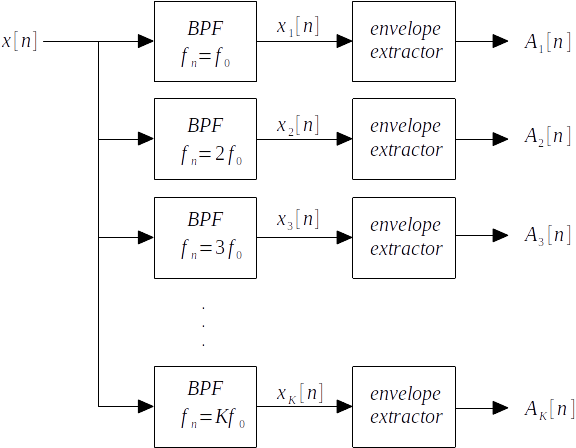

For instance, the following code should extract the envelope of the fundamental frequency component. Change the value of $f_0$ to coincide with your fundamental frequency and check the result. 

In [13]:
f0 = # put your fundamental frequency here
x_1 = bpf(x, f0, fs)
A_1 = envelope_iir(x_1, r=0.999)
plot_signals([x_1, A_1], fs, t_start=0, t_end=1.5, name=['x_1(t)', 'A_1(t)'])

SyntaxError: invalid syntax (872390976.py, line 1)

2.6 Complete the `synthetize_with_bpf` function to implement a synthesis applying different envelopes for each harmonic.


In [ ]:
def synthetize_with_bpf(x, f0, phi, K, fs):
  """Synthetizes an harmonic signal using different envelopes for each harmonic
  The envelops are extracted from the reference signal x.

  Parameters
  ----------
  x : np.array
      The reference signal in the form of a numpy array
  f0: int or float
      Fundamental frequency of the synthesis
  phi : float
      Phase
  K: int
      Number of harmonics
  fs : int or float
      Frequency rate in Hz

  Returns
  -------
  y : np.array
      The output of the filter

  """
  Ts = 1/float(fs)
  t = np.arange(0, len(x)*Ts, Ts)

  y = 0
  for k in range(1, int(K) + 1):
    x_k = # output of the BPF filter
    A_k = # output of the envelope extractor
    y += A_k * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)

  y = np.amax(x)*y/np.amax(y) # normalize the output
  return y

2.6 Call the function `synthetize_with_bpf` to get the synthesized signal and **listen to it**.

Note that now you can increase the number of harmonics $K$ as you want because we are not manually measuring the weights of each harmonic.

In [ ]:
# Write your code here

2.7 Compare the **spectrograms** of the synthesized signal and reference signal.

In [ ]:
# Write your code here